# Lista prática V

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

**Dica:** Considere usar o Google Colab

## Redução de dimensionalidade

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [10]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SklearnPCA

# Carregando o conjunto de dados a partir do caminho fornecido
df = pd.read_csv("./penguins.csv", header=None)

# Nomes das colunas para facilitar a manipulação
df.columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species']

# Lidando com valores ausentes (se houver no arquivo local)
df.dropna(inplace=True)

# Separando features (X) e rótulos (y)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalizando os dados
# É uma etapa crucial para o PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dimensões dos dados normalizados (amostras, atributos):", X_scaled.shape)

Dimensões dos dados normalizados (amostras, atributos): (333, 4)


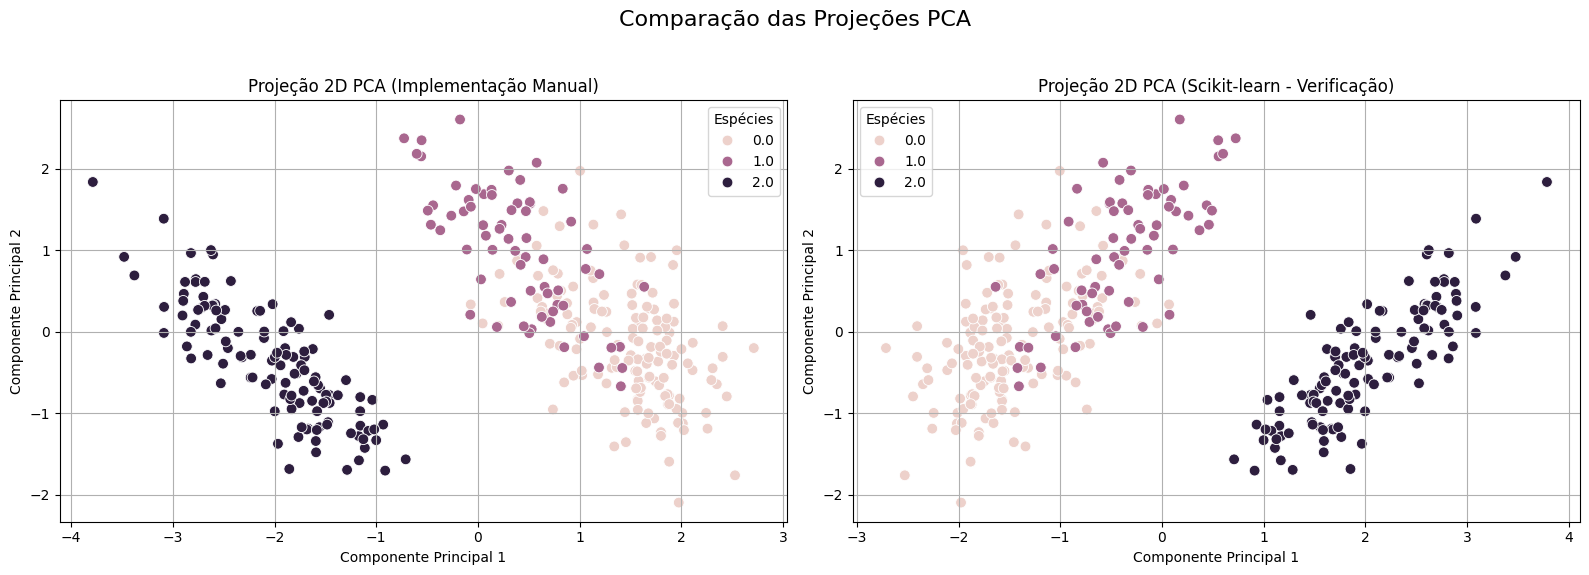

In [3]:
# --- Implementação Manual do PCA ---

# 1. Calcular a matriz de covariância
# (features, features)
cov_matrix = np.cov(X_scaled.T)

# 2. Calcular autovetores e autovalores
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# 3. Ordenar autovetores pelos autovalores
# Invertemos a ordem para que seja decrescente
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# 4. Selecionar os 2 principais autovetores
# A matriz de projeção terá dimensão (features, 2)
projection_matrix = sorted_eigenvectors[:, :2]

# 5. Projetar os dados no novo espaço 2D
X_pca_manual = X_scaled.dot(projection_matrix)

# Criando um DataFrame para facilitar a visualização
df_pca_manual = pd.DataFrame(data=X_pca_manual, columns=['PC1', 'PC2'])
df_pca_manual['species'] = y

# --- Verificação com Scikit-learn ---
pca_sklearn = SklearnPCA(n_components=2)
X_pca_sklearn = pca_sklearn.fit_transform(X_scaled)
df_pca_sklearn = pd.DataFrame(data=X_pca_sklearn, columns=['PC1', 'PC2'])
df_pca_sklearn['species'] = y


# --- Visualização dos Resultados ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico da implementação manual
sns.scatterplot(x='PC1', y='PC2', data=df_pca_manual, hue='species', ax=axes[0], s=60)
axes[0].set_title('Projeção 2D PCA (Implementação Manual)')
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True)
axes[0].legend(title='Espécies')

# Gráfico da implementação do Scikit-learn
sns.scatterplot(x='PC1', y='PC2', data=df_pca_sklearn, hue='species', ax=axes[1], s=60)
axes[1].set_title('Projeção 2D PCA (Scikit-learn - Verificação)')
axes[1].set_xlabel('Componente Principal 1')
axes[1].set_ylabel('Componente Principal 2')
axes[1].grid(True)
axes[1].legend(title='Espécies')

plt.suptitle("Comparação das Projeções PCA", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Análise da Variância Explicada ---
Dimensão projetada = 1:
  - Variância explicada individual (PC1): 0.6863 (68.63%)
  - Variância explicada acumulada: 0.6863 (68.63%)

Dimensão projetada = 2:
  - Variância explicada individual (PC2): 0.1945 (19.45%)
  - Variância explicada acumulada: 0.8809 (88.09%)

Dimensão projetada = 3:
  - Variância explicada individual (PC3): 0.0922 (9.22%)
  - Variância explicada acumulada: 0.9730 (97.30%)

Dimensão projetada = 4:
  - Variância explicada individual (PC4): 0.0270 (2.70%)
  - Variância explicada acumulada: 1.0000 (100.00%)


--- Verificação com Scikit-learn ---
Variância explicada por componente: [0.68633893 0.19452929 0.09216063 0.02697115]


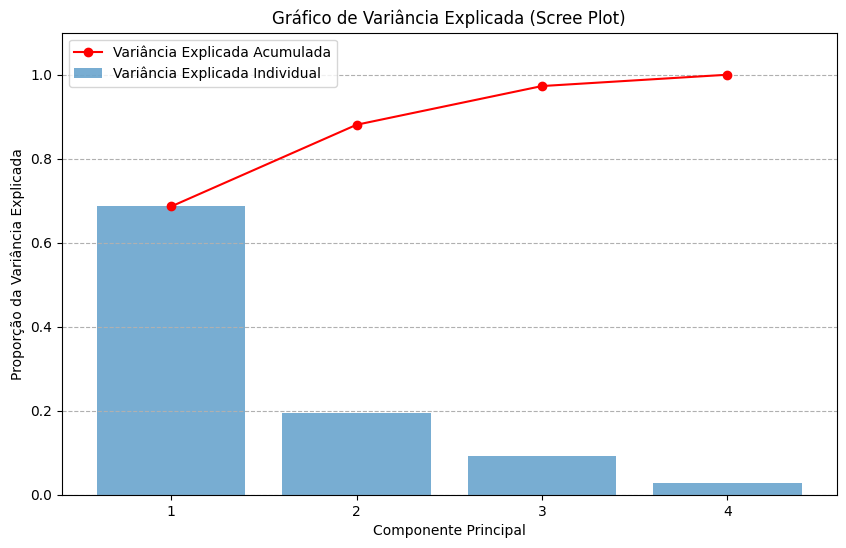

In [4]:
# Usando os autovalores calculados na implementação manual
total_eigenvalues_sum = np.sum(sorted_eigenvalues)

# Calculando a variância explicada por cada componente
explained_variance_ratio = sorted_eigenvalues / total_eigenvalues_sum

# Calculando a variância explicada acumulada
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("--- Análise da Variância Explicada ---")
for i in range(len(cumulative_explained_variance)):
    print(f"Dimensão projetada = {i+1}:")
    print(f"  - Variância explicada individual (PC{i+1}): {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")
    print(f"  - Variância explicada acumulada: {cumulative_explained_variance[i]:.4f} ({cumulative_explained_variance[i]*100:.2f}%)\n")

# --- Verificação com Scikit-learn ---
pca_sklearn_full = SklearnPCA(n_components=4)
pca_sklearn_full.fit(X_scaled)
print("\n--- Verificação com Scikit-learn ---")
print(f"Variância explicada por componente: {pca_sklearn_full.explained_variance_ratio_}")


# --- Gráfico da Variância Explicada (Scree Plot) ---
plt.figure(figsize=(10, 6))
num_components = len(explained_variance_ratio)
component_indices = np.arange(1, num_components + 1)

# Barras para variância individual
plt.bar(component_indices, explained_variance_ratio, alpha=0.6, align='center',
        label='Variância Explicada Individual')

# Linha para variância acumulada
plt.plot(component_indices, cumulative_explained_variance, 'o-', color='r',
         label='Variância Explicada Acumulada')

plt.ylabel('Proporção da Variância Explicada')
plt.xlabel('Componente Principal')
plt.title('Gráfico de Variância Explicada (Scree Plot)')
plt.xticks(component_indices)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='best')
plt.show()

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [5]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.63MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 192kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 235kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.76MB/s]


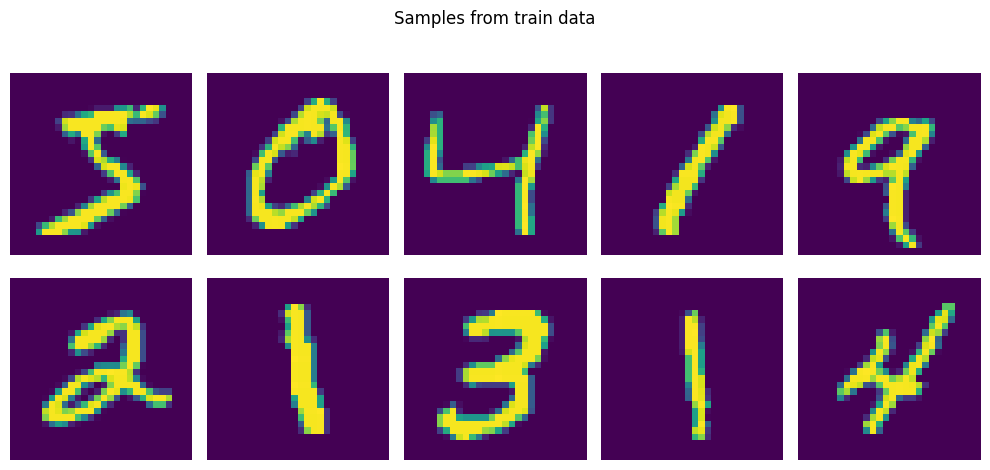

In [6]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

In [7]:
# Configurando o dispositivo (GPU se disponível, senão CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Hiperparâmetros
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1 # 10% para validação
N_EPOCHS = 50
LEARNING_RATE = 1e-3
LATENT_DIM = 2 # Dimensão do espaço latente (conforme solicitado)
PATIENCE = 5 # Paciência para o early stopping

# Divisão do dataset em treino e validação
train_size = int((1.0 - VALIDATION_SPLIT) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Criando DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Tamanho do conjunto de treino: {len(train_dataset)} amostras")
print(f"Tamanho do conjunto de validação: {len(val_dataset)} amostras")
print(f"Tamanho do conjunto de teste: {len(test_dataset)} amostras")

Usando dispositivo: mps
Tamanho do conjunto de treino: 54000 amostras
Tamanho do conjunto de validação: 6000 amostras
Tamanho do conjunto de teste: 10000 amostras


In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Encoder
        # Entrada: (N, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # -> (N, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (N, 32, 7, 7)
            nn.ReLU(),
            nn.Flatten(), # -> (N, 32 * 7 * 7) = (N, 1568)
            nn.Linear(32 * 7 * 7, latent_dim) # -> (N, latent_dim)
        )
        
        # Decoder
        # Entrada: (N, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7), # -> (N, 1568)
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)), # -> (N, 32, 7, 7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (N, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (N, 1, 28, 28)
            nn.Sigmoid() # Garante que a saída esteja no intervalo [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instanciando o modelo
model = Autoencoder(latent_dim=LATENT_DIM).to(device)
criterion = nn.MSELoss() # Erro quadrático médio para a reconstrução
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Scheduler para anelar a taxa de aprendizado com base na perda de validação
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): Sigmoid()
  )
)


In [10]:
def train_model(model, n_epochs, train_loader, val_loader, optimizer, criterion, scheduler, patience, device):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    start_time = time.time()

    for epoch in range(n_epochs):
        # --- Treinamento ---
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- Validação ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Atualiza o scheduler
        scheduler.step(val_loss)

        # --- Lógica de Early Stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Salva o melhor modelo
            torch.save(model.state_dict(), 'best_autoencoder.pth')
            #print("Modelo salvo. Perda de validação melhorou.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    end_time = time.time()
    print(f"\nTreinamento concluído em {(end_time - start_time)/60:.2f} minutos.")
    
    # Carrega os pesos do melhor modelo
    model.load_state_dict(torch.load('best_autoencoder.pth'))
    return model, history

# Treinando o modelo
model, history = train_model(model, N_EPOCHS, train_loader, val_loader, optimizer, criterion, scheduler, PATIENCE, device)

Epoch [1/50], Train Loss: 0.101109, Val Loss: 0.063545
Epoch [2/50], Train Loss: 0.060317, Val Loss: 0.058517
Epoch [3/50], Train Loss: 0.057545, Val Loss: 0.056586
Epoch [4/50], Train Loss: 0.055966, Val Loss: 0.055321
Epoch [5/50], Train Loss: 0.054905, Val Loss: 0.054421
Epoch [6/50], Train Loss: 0.054126, Val Loss: 0.053710
Epoch [7/50], Train Loss: 0.053543, Val Loss: 0.053191
Epoch [8/50], Train Loss: 0.053062, Val Loss: 0.052744
Epoch [9/50], Train Loss: 0.052653, Val Loss: 0.052360
Epoch [10/50], Train Loss: 0.052317, Val Loss: 0.052076
Epoch [11/50], Train Loss: 0.052008, Val Loss: 0.051751
Epoch [12/50], Train Loss: 0.051695, Val Loss: 0.051398
Epoch [13/50], Train Loss: 0.051375, Val Loss: 0.051092
Epoch [14/50], Train Loss: 0.051051, Val Loss: 0.050763
Epoch [15/50], Train Loss: 0.050737, Val Loss: 0.050487
Epoch [16/50], Train Loss: 0.050447, Val Loss: 0.050269
Epoch [17/50], Train Loss: 0.050183, Val Loss: 0.049886
Epoch [18/50], Train Loss: 0.049873, Val Loss: 0.049686
E

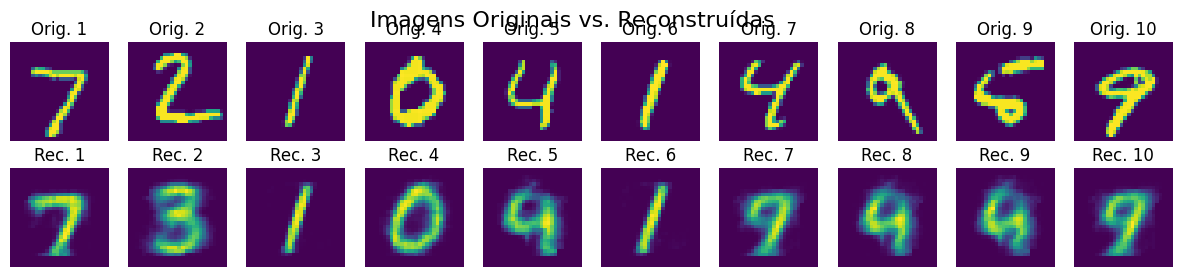

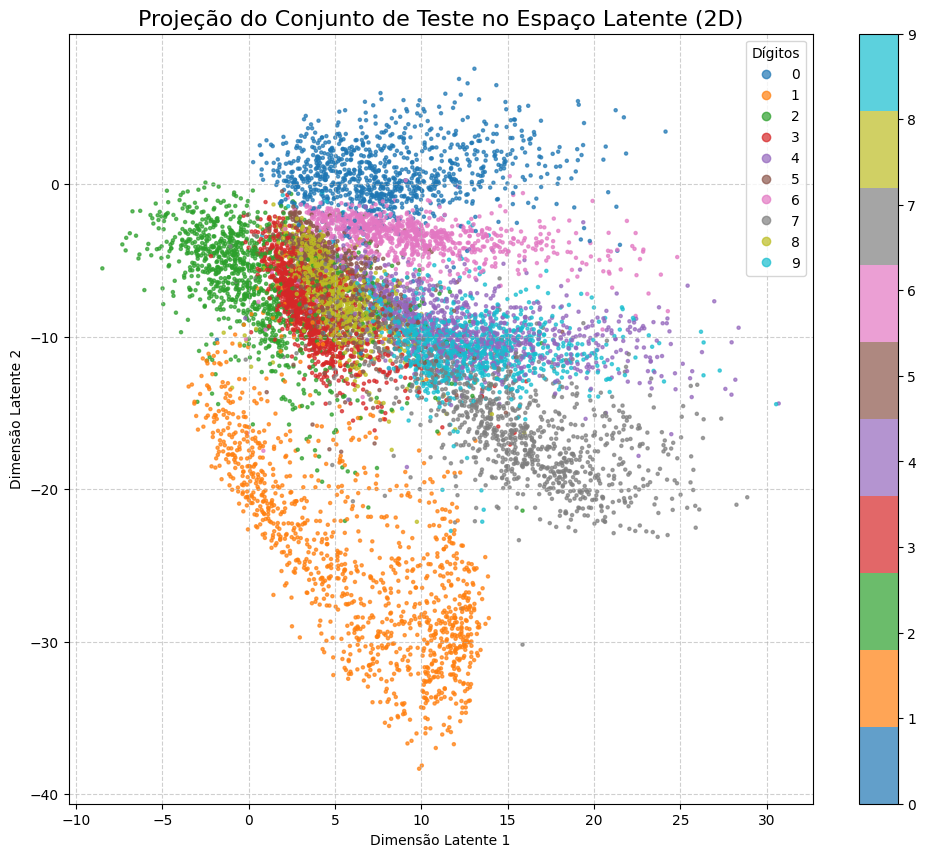

In [11]:
def visualize_results(model, test_loader, device):
    model.eval()
    
    # --- 1. Visualizar imagens reconstruídas ---
    with torch.no_grad():
        # Pega um batch de imagens de teste
        images, _ = next(iter(test_loader))
        images = images.to(device)
        
        # Gera as reconstruções
        reconstructed_images = model(images).cpu()

    # Prepara para plotar
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    fig.suptitle("Imagens Originais vs. Reconstruídas", fontsize=16)
    for i in range(10):
        # Originais
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='viridis')
        axes[0, i].set_title(f"Orig. {i+1}")
        axes[0, i].axis('off')
        
        # Reconstruídas
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='viridis')
        axes[1, i].set_title(f"Rec. {i+1}")
        axes[1, i].axis('off')
    plt.show()

    # --- 2. Visualizar o espaço latente ---
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for images, lbls in test_loader:
            images = images.to(device)
            # Apenas a parte do encoder é usada aqui
            encoded = model.encoder(images)
            latent_vectors.append(encoded.cpu())
            labels.append(lbls)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    plt.title('Projeção do Conjunto de Teste no Espaço Latente (2D)', fontsize=16)
    plt.xlabel('Dimensão Latente 1')
    plt.ylabel('Dimensão Latente 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=range(10), title="Dígitos")
    plt.colorbar(scatter)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Gerando as visualizações com o modelo treinado
visualize_results(model, test_loader, device)

Os resultados demonstram que o autoencoder foi treinado com sucesso para aprender uma representação compacta e significativa dos dígitos MNIST.

1.  **Nas Imagens Reconstruídas:** A primeira imagem mostra que o modelo consegue capturar a essência de cada dígito. As imagens reconstruídas são mais borradas que as originais, o que é esperado devido à **extrema compressão** (de 784 para apenas 2 dimensões). Mesmo com essa perda de informação, um "7" ainda é reconstruído como um "7", mostrando que o modelo aprendeu as características mais importantes.

2.  **No Espaço Latente (2D):** A segunda imagem revela o porquê de as reconstruções serem possíveis. O encoder não espalhou as imagens aleatoriamente; ele as **organizou de forma estruturada**. Dígitos da mesma classe formam clusters (agrupamentos) distintos. Por exemplo, o dígito "1" (laranja) cria um cluster bem definido e separado. Dígitos visualmente semelhantes, como "4", "7" e "9", estão mais próximos e até se sobrepõem, o que faz sentido intuitivo.

Em resumo, o autoencoder aprendeu com sucesso um "mapa" 2D dos dígitos, agrupando-os por similaridade visual, tudo isso de forma não supervisionada (sem usar os rótulos durante o treino).

## K-means e Mixture models

## Exercícios práticos

In [12]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:20<00:00, 1.29MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]
100%|██████████| 4.42M/4.42M [00:06<00:00, 721kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.92MB/s]


In [13]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

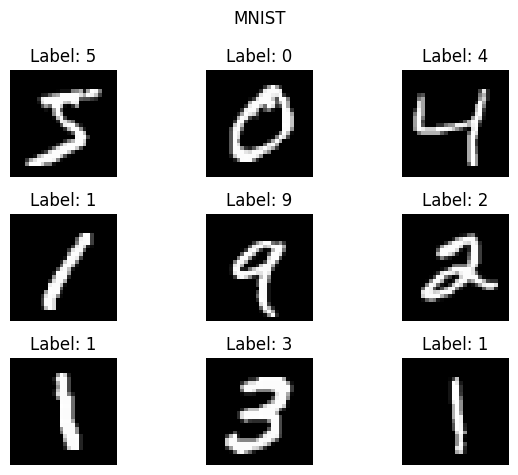

In [14]:
display_nine_images(mnist_trainset)

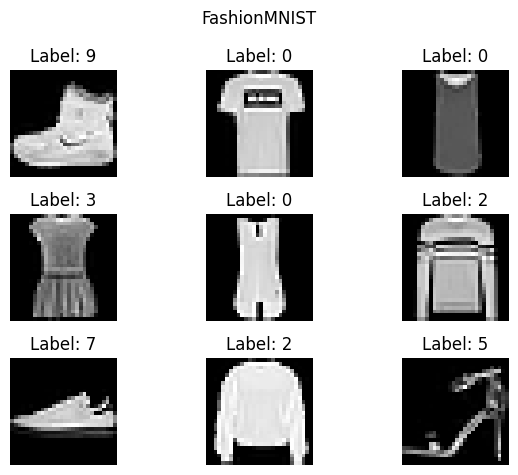

In [15]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm

# Carregar os dados
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

# Achatar as imagens e converter para numpy
# Usaremos um subconjunto para agilizar o processo
num_samples = 10000
X_train = mnist_trainset.data[:num_samples].numpy().reshape(num_samples, -1) / 255.0
y_train = mnist_trainset.targets[:num_samples].numpy()

print(f"Dimensão dos dados de entrada (amostras, features): {X_train.shape}")
print(f"Dimensão dos rótulos: {y_train.shape}")

Dimensão dos dados de entrada (amostras, features): (10000, 784)
Dimensão dos rótulos: (10000,)


In [17]:
class KMeans:
    def __init__(self, k=10, max_iters=100, init_strategy='kmeans++'):
        self.k = k
        self.max_iters = max_iters
        self.init_strategy = init_strategy
        self.centroids = None

    def _initialize_centroids(self, X):
        n_samples, n_features = X.shape
        
        if self.init_strategy == 'random':
            random_indices = np.random.choice(n_samples, self.k, replace=False)
            self.centroids = X[random_indices]
            
        elif self.init_strategy == 'kmeans++':
            centroids = np.zeros((self.k, n_features))
            # 1. Escolher o primeiro centroide aleatoriamente
            centroids[0] = X[np.random.randint(n_samples)]
            
            for i in range(1, self.k):
                # 2. Calcular a distância ao quadrado de cada ponto ao centroide mais próximo
                dist_sq = np.array([min([np.inner(c-x, c-x) for c in centroids[:i]]) for x in X])
                
                # 3. Escolher o próximo centroide com probabilidade proporcional a essa distância
                probs = dist_sq / dist_sq.sum()
                cumulative_probs = probs.cumsum()
                r = np.random.rand()
                
                for j, p in enumerate(cumulative_probs):
                    if r < p:
                        centroids[i] = X[j]
                        break
            self.centroids = centroids

    def _assign_clusters(self, X):
        # Calcula a distância Euclidiana de cada ponto a todos os centroides
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        # Atribui cada ponto ao cluster do centroide mais próximo
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
        return new_centroids

    def fit(self, X, initial_centroids=None):
        if initial_centroids is not None:
            self.centroids = initial_centroids
        else:
            self._initialize_centroids(X)
        
        for i in tqdm(range(self.max_iters), desc=f"Executando K-means ({self.init_strategy})"):
            labels = self._assign_clusters(X)
            
            new_centroids = self._update_centroids(X, labels)
            
            # Critério de parada: se os centroides não mudarem mais
            if np.allclose(self.centroids, new_centroids):
                print(f"\nConvergência alcançada na iteração {i+1}.")
                break
                
            self.centroids = new_centroids
            
        return self._assign_clusters(X) # Retorna as labels finais

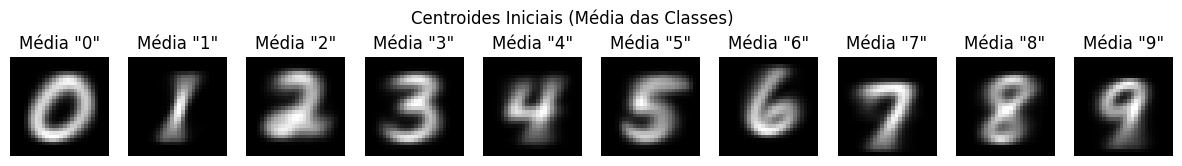

Executando K-means (kmeans++):  86%|████████▌ | 86/100 [00:10<00:01,  7.93it/s]



Convergência alcançada na iteração 87.


In [18]:
# Calcular a média de cada classe para usar como centroides iniciais
mean_centroids = np.zeros((10, X_train.shape[1]))
for i in range(10):
    mean_centroids[i] = X_train[y_train == i].mean(axis=0)

# Visualizando os centroides "ideais"
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, centroid in enumerate(mean_centroids):
    axes[i].imshow(centroid.reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Média "{i}"')
    axes[i].axis('off')
fig.suptitle('Centroides Iniciais (Média das Classes)')
plt.show()

# Executando o K-means com esta inicialização
kmeans_supervised = KMeans(k=10)
supervised_labels = kmeans_supervised.fit(X_train, initial_centroids=mean_centroids)

In [19]:
kmeans_plus_plus = KMeans(k=10, init_strategy='kmeans++')
kmeans_plus_plus_labels = kmeans_plus_plus.fit(X_train)

Executando K-means (kmeans++):  51%|█████     | 51/100 [00:06<00:06,  8.02it/s]



Convergência alcançada na iteração 52.


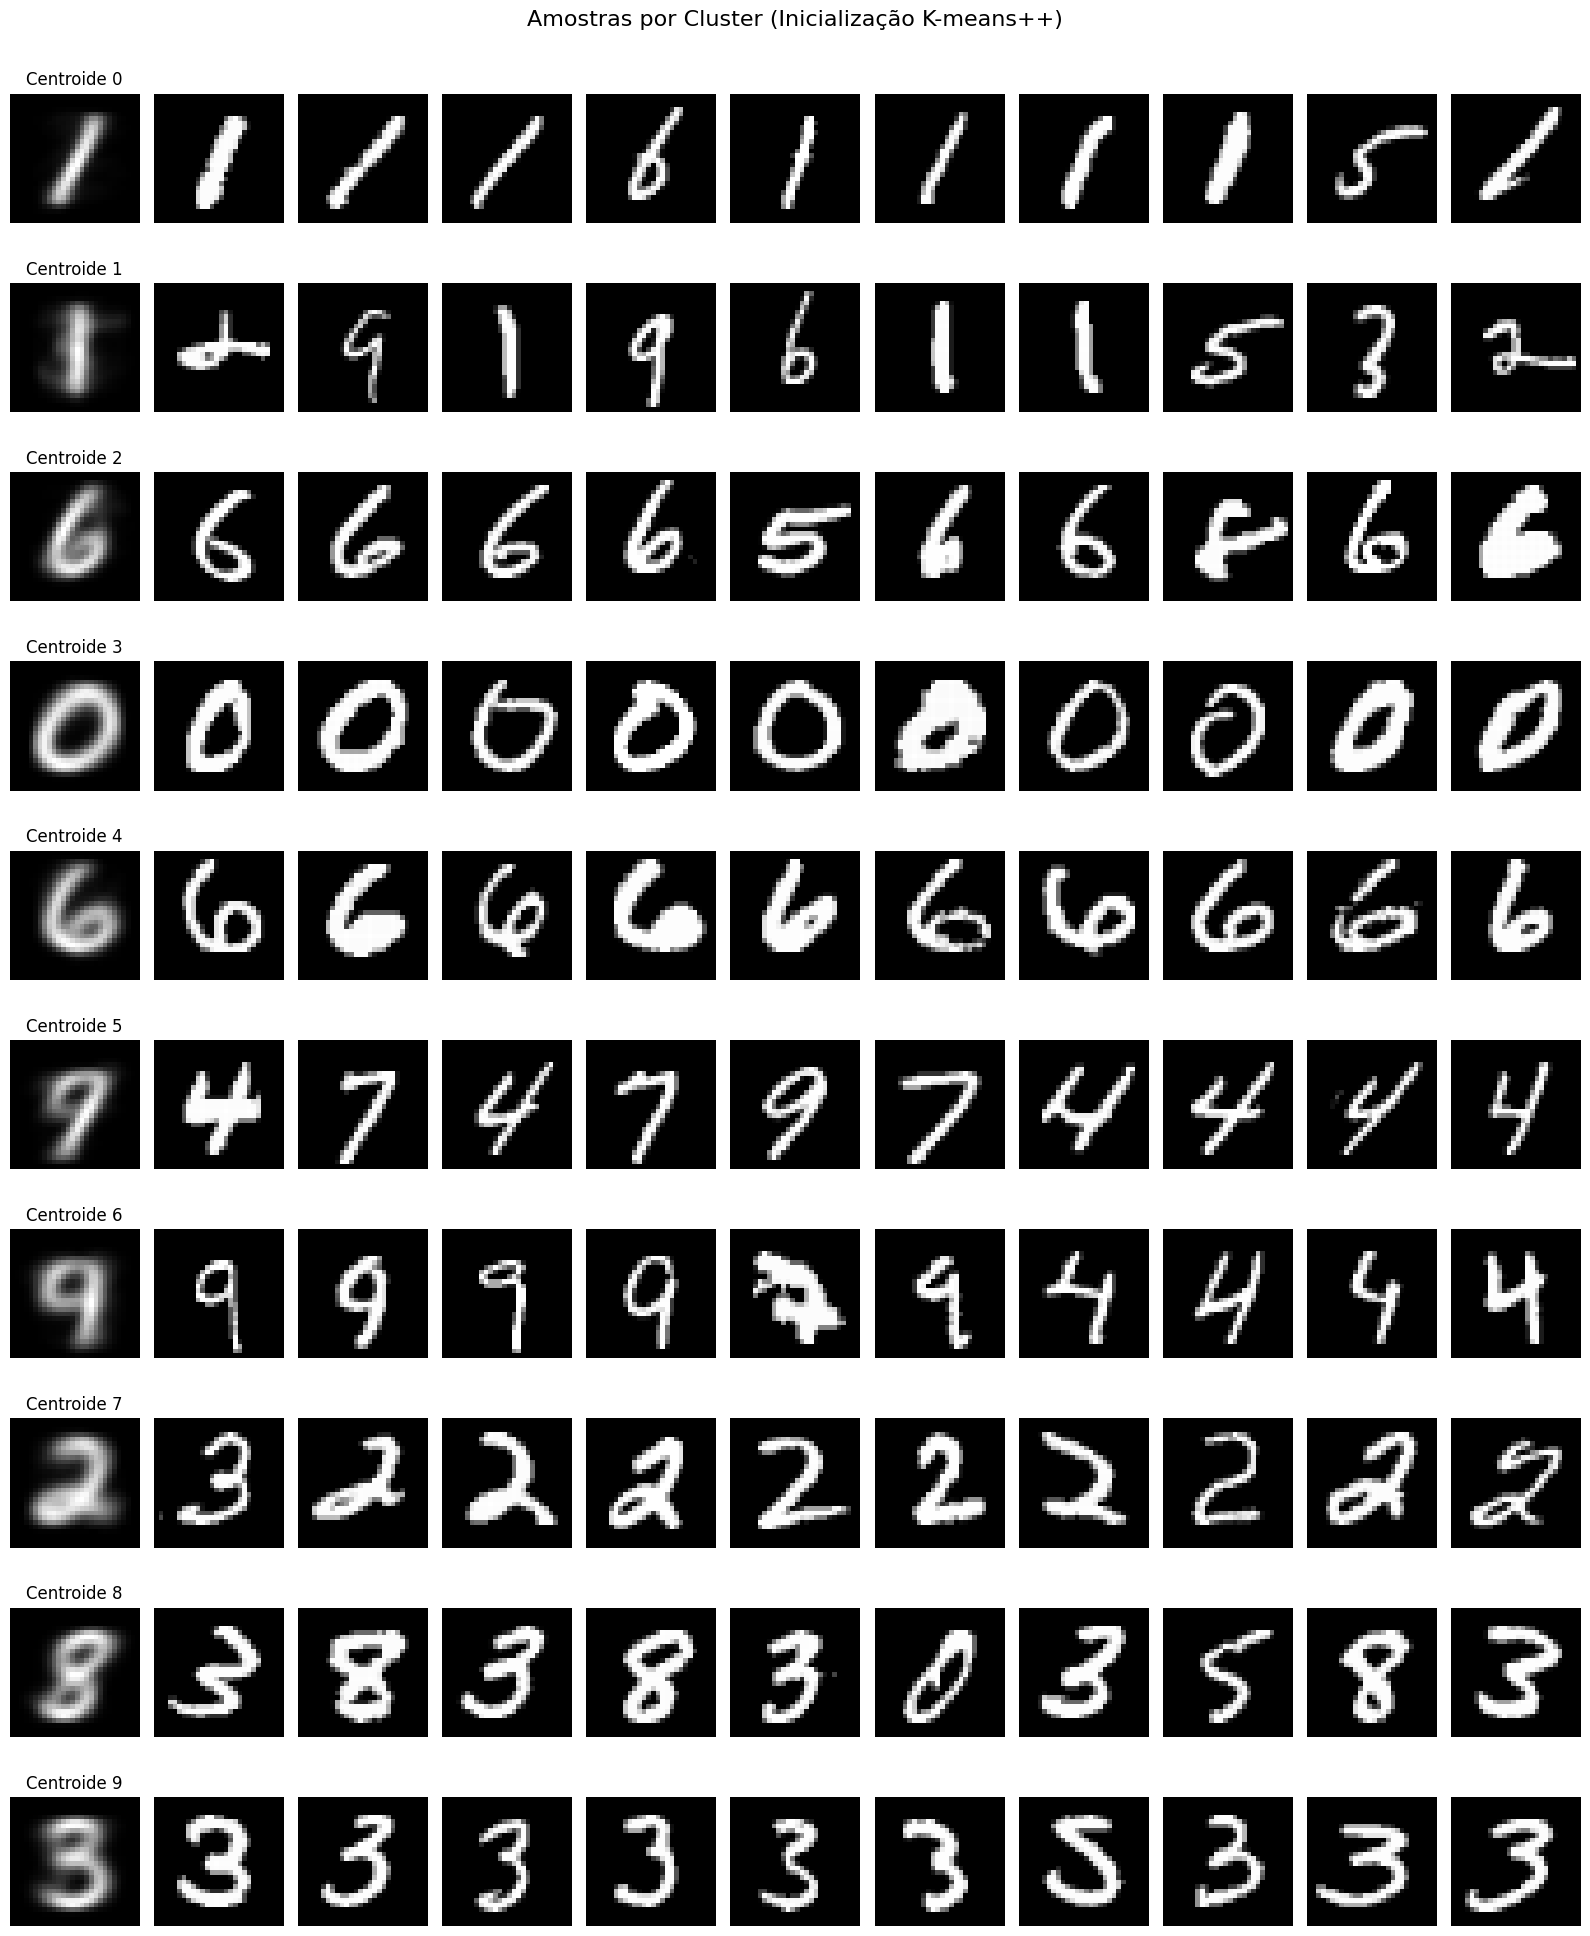

In [20]:
def plot_clusters(X, labels, centroids, k=10):
    plt.figure(figsize=(16, 20))
    
    # Para cada cluster
    for i in range(k):
        # Encontra os índices das imagens que pertencem a este cluster
        cluster_indices = np.where(labels == i)[0]
        
        # Se o cluster não estiver vazio
        if len(cluster_indices) > 0:
            # Pega 10 amostras aleatórias do cluster
            sample_indices = np.random.choice(cluster_indices, min(10, len(cluster_indices)), replace=False)
            
            # Plota o centroide do cluster
            plt.subplot(k, 11, i * 11 + 1)
            plt.imshow(centroids[i].reshape(28, 28), cmap='gray')
            plt.title(f'Centroide {i}')
            plt.axis('off')
            
            # Plota as amostras
            for j, sample_idx in enumerate(sample_indices):
                plt.subplot(k, 11, i * 11 + j + 2)
                plt.imshow(X[sample_idx].reshape(28, 28), cmap='gray')
                plt.axis('off')

    plt.suptitle('Amostras por Cluster (Inicialização K-means++)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Visualizando os clusters encontrados pelo K-means++
plot_clusters(X_train, kmeans_plus_plus_labels, kmeans_plus_plus.centroids)

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Configurações
device = torch.device("mps" if torch.mps.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

# Carregar os datasets
transform = torchvision.transforms.ToTensor()
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fashion_mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)
ood_loader = DataLoader(fashion_mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

# Definindo o MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # Separamos o extrator de features da camada de classificação final
        self.feature_extractor = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128) # Esta é a penúltima camada
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        # As ativações que queremos modelar
        features = self.feature_extractor(x)
        # Passamos as features pelo classificador
        logits = self.classifier(features)
        return logits

# Treinamento do MLP
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("--- Treinando o MLP no MNIST ---")
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Teste de acurácia a cada época
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.2f}%')

--- Treinando o MLP no MNIST ---
Epoch [1/10], Loss: 0.1323, Test Accuracy: 94.10%
Epoch [2/10], Loss: 0.2457, Test Accuracy: 96.08%
Epoch [3/10], Loss: 0.1440, Test Accuracy: 96.80%
Epoch [4/10], Loss: 0.0256, Test Accuracy: 97.40%
Epoch [5/10], Loss: 0.1239, Test Accuracy: 97.65%
Epoch [6/10], Loss: 0.0167, Test Accuracy: 97.55%
Epoch [7/10], Loss: 0.0259, Test Accuracy: 97.74%
Epoch [8/10], Loss: 0.0112, Test Accuracy: 97.79%
Epoch [9/10], Loss: 0.0132, Test Accuracy: 97.55%
Epoch [10/10], Loss: 0.0100, Test Accuracy: 97.80%


In [23]:
def get_activations(model, data_loader):
    """Função auxiliar para extrair as ativações da penúltima camada."""
    model.eval()
    activations = []
    with torch.no_grad():
        for images, _ in tqdm(data_loader, desc="Extraindo ativações"):
            images = images.to(device)
            # Passamos as imagens apenas pelo extrator de features
            feats = model.feature_extractor(model.flatten(images))
            activations.append(feats.cpu().numpy())
    return np.concatenate(activations)

# Extrair ativações dos dados de TREINO do MNIST
train_activations = get_activations(model, DataLoader(mnist_trainset, batch_size=BATCH_SIZE))
print(f"Dimensão das ativações de treino: {train_activations.shape}")

# Treinar o GMM
# Começaremos com n_components=10, mas vamos testar outros valores depois
n_components_test = 10
print(f"\n--- Treinando GMM com {n_components_test} componentes ---")
gmm = GaussianMixture(n_components=n_components_test, covariance_type='diag', random_state=42)
gmm.fit(train_activations)
print("GMM treinado com sucesso.")

Extraindo ativações: 100%|██████████| 235/235 [00:01<00:00, 167.79it/s]


Dimensão das ativações de treino: (60000, 128)

--- Treinando GMM com 10 componentes ---
GMM treinado com sucesso.


Extraindo ativações: 100%|██████████| 40/40 [00:00<00:00, 176.05it/s]


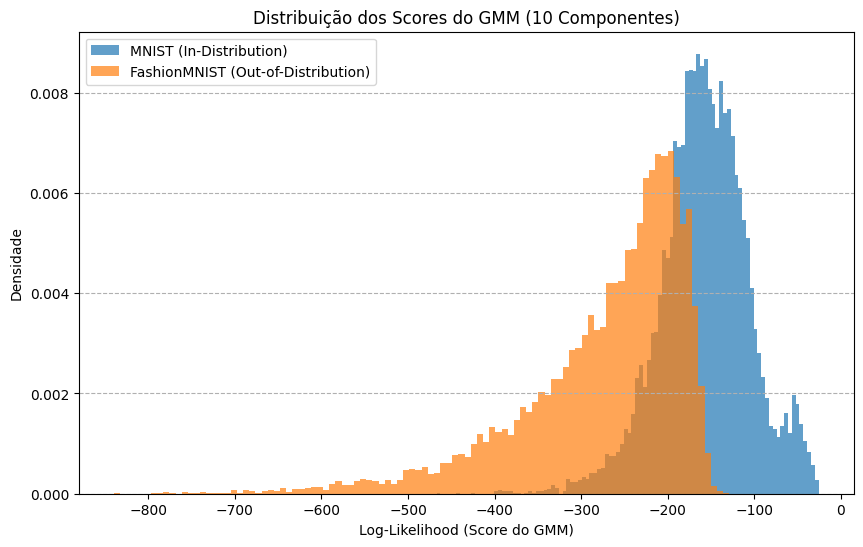

In [24]:
# Extrair ativações dos dados de TESTE (ID e OOD)
id_activations = get_activations(model, test_loader)
ood_activations = get_activations(model, ood_loader)

# Calcular o log-likelihood para cada amostra
id_scores = gmm.score_samples(id_activations)
ood_scores = gmm.score_samples(ood_activations)

# Plotar histogramas para visualização
plt.figure(figsize=(10, 6))
plt.hist(id_scores, bins=100, alpha=0.7, density=True, label='MNIST (In-Distribution)')
plt.hist(ood_scores, bins=100, alpha=0.7, density=True, label='FashionMNIST (Out-of-Distribution)')
plt.xlabel('Log-Likelihood (Score do GMM)')
plt.ylabel('Densidade')
plt.title(f'Distribuição dos Scores do GMM ({n_components_test} Componentes)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

Testando com 1 componentes...
  AUROC: 0.6409
Testando com 2 componentes...
  AUROC: 0.6686
Testando com 4 componentes...
  AUROC: 0.8079
Testando com 8 componentes...
  AUROC: 0.8830
Testando com 16 componentes...
  AUROC: 0.9441
Testando com 32 componentes...
  AUROC: 0.9430
Testando com 64 componentes...
  AUROC: 0.9586
Testando com 128 componentes...
  AUROC: 0.9586

Melhor número de componentes: 128 (AUROC = 0.9586)


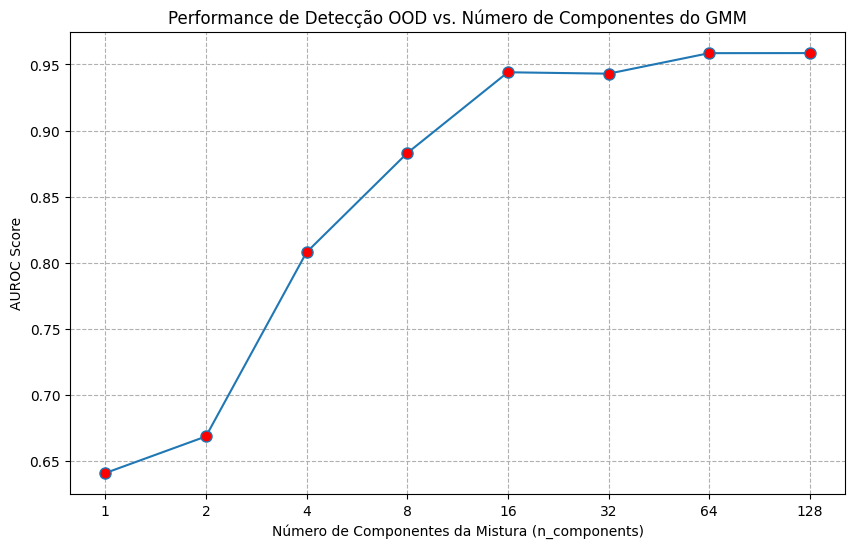

In [25]:
n_components_range = [1, 2, 4, 8, 16, 32, 64, 128]
auroc_scores = []

# Combinando scores e criando labels verdadeiras para o cálculo do AUROC
# 1 para in-distribution, 0 para out-of-distribution
y_true = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])

for n_comp in n_components_range:
    print(f"Testando com {n_comp} componentes...")
    # Treina o GMM
    gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', random_state=42)
    gmm.fit(train_activations)
    
    # Calcula os scores
    id_scores_test = gmm.score_samples(id_activations)
    ood_scores_test = gmm.score_samples(ood_activations)
    
    y_scores = np.concatenate([id_scores_test, ood_scores_test])
    
    # Calcula e armazena o AUROC
    auroc = roc_auc_score(y_true, y_scores)
    auroc_scores.append(auroc)
    print(f"  AUROC: {auroc:.4f}")

# Encontrando o melhor resultado
best_idx = np.argmax(auroc_scores)
best_n_components = n_components_range[best_idx]
best_auroc = auroc_scores[best_idx]

print(f"\nMelhor número de componentes: {best_n_components} (AUROC = {best_auroc:.4f})")

# Plotar o resultado
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, auroc_scores, 'o-', markerfacecolor='red', markersize=8)
plt.xlabel('Número de Componentes da Mistura (n_components)')
plt.ylabel('AUROC Score')
plt.title('Performance de Detecção OOD vs. Número de Componentes do GMM')
plt.xscale('log', base=2)
plt.xticks(n_components_range, labels=n_components_range)
plt.grid(True, which="both", ls="--")
plt.show()

Em resumo, o experimento validou com sucesso o uso de um Modelo de Mistura Gaussiana (GMM) para identificar dados anômalos (out-of-distribution).

A estratégia foi treinar um GMM sobre as características internas de uma rede neural que aprendeu a classificar o MNIST. O GMM efetivamente criou um modelo de "normalidade" para os dígitos. Ao ser testado, este modelo atribuiu probabilidades muito baixas às imagens do FashionMNIST, permitindo uma separação clara entre os dados vistos no treino e os dados anômalos.

A principal conclusão é que a performance da detecção depende diretamente da complexidade do GMM. O poder de separação aumentou com o número de componentes, atingindo um resultado excelente (AUROC de 0.96) com 64 componentes, provando ser uma abordagem robusta e eficaz.